In [1]:
import numpy as np
import numba
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys
import os

from eigenwell.src import grid, pml, pec_pmc
from eigenwell.src.constants import *

from scipy.sparse.linalg import splu

#import eigenwell.boundary
print(os.listdir())


['.DS_Store', '2d photonic crystal.ipynb', 'eigensolving with SLEPc.ipynb', 'dielectric waveguide analytic comparison.ipynb', 'check_pml.ipynb', 'test_grid_preconditioners.ipynb', 'complex_waveguides_with_impedance_transformations.ipynb', '3D perfect metal waveguide solve.ipynb', 'mode_filtering.ipynb', 'K-eigensolver 1D Bragg Mirror-1D Photonic Crystal.ipynb', 'test_bloch_boundary.ipynb', 'TE vs TM.ipynb', 'non uniform grid.ipynb', '.ipynb_checkpoints', 'array ordering of numpy.ipynb', 'dielectric waveguide.ipynb', 'IMI-MIM k-eigensolver.ipynb']


## Equations for a general waveguide with propagation constant $\beta$ in z
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}

In full operator notation
\begin{equation}
    \omega^2 \mu_0 \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}     \begin{bmatrix}
        -D_y^{f} \\
        D_x^{f}
    \end{bmatrix} T_{\epsilon_z}^{-1} \begin{bmatrix}
        -D_y^{b} &
        D_x^{b}
    \end{bmatrix} +\begin{bmatrix}
        D_x^{b} \\
        D_y^{b}
    \end{bmatrix} \begin{bmatrix}
        D_x^{f} &
        D_y^{f}
    \end{bmatrix}
\end{equation}



In [2]:
def grid_average(center_array, w):
    '''
        center_array, 1d eps_r
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array

[-5e-07, 5e-07]


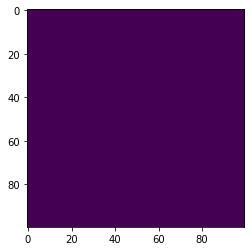

(20000, 10000)
(20000, 20000) <class 'scipy.sparse.csr.csr_matrix'>
2.511562061214068 1.2566370614359173e-06 96048


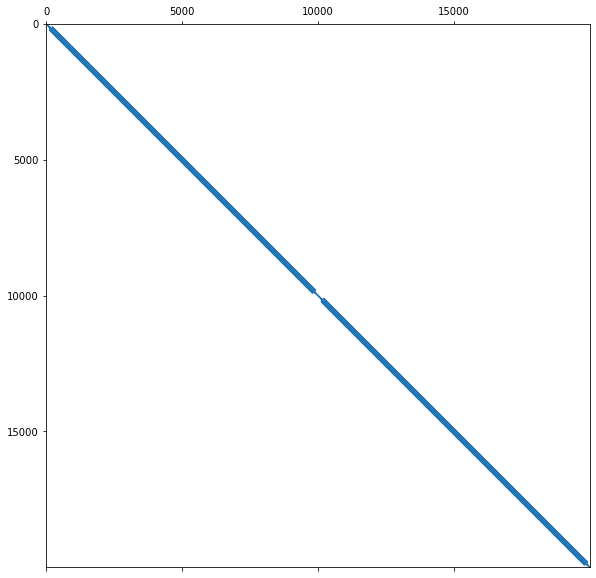

In [3]:
L0 = 1e-6

N = [100,100]
Npml = [5,5]
dL = [0.01*L0, 0.01*L0]
Lx, Ly = [N[0]*dL[0], N[1]*dL[1]]
xrange = [-Lx/2, Lx/2]
yrange = [-Ly/2, Ly/2]
print(xrange)

wvlen = 0.75e-6;

omega = 2*np.pi*C0/wvlen;

pml_obj =  pml.PML(N,Npml, omega);
pml_obj.Soperators(xrange, yrange);

pec_pmc_obj = pec_pmc.PEC_PMC(N);

epsilon = np.ones(N)
#epsilon[30:70, 30:70] = 5
plt.figure();
plt.imshow(epsilon);
plt.show();
M = np.prod(N)
epxx= grid_average(epsilon,'x')
epyy = grid_average(epsilon, 'y')

Tez = sp.diags(EPSILON0*epsilon.flatten(), 0, (M,M))
Tey = sp.diags(EPSILON0*epyy.flatten(), 0, (M,M))
Tex = sp.diags(EPSILON0*epxx.flatten(), 0,(M,M))
invTez = sp.diags(1/(EPSILON0*epsilon.flatten()), 0, (M,M))

fd = grid.FiniteDifferenceGrid(dL,N)
mx = pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;

#fd.make_derivatives(PML = None, PEC_PMC = pec_pmc)
Dxf = fd.Dxf
Dxb = fd.Dxb
Dyf = fd.Dyf
Dyb = fd.Dyb

Mx = sp.bmat([[mx, None],
              [None,mx]])
My = sp.bmat([[my, None],
              [None,my]])

## generate operator
Dop1 = sp.bmat([[-Dyf], [Dxf]])
print(Dop1.shape)

Dop2 = sp.bmat([[-Dyb,Dxb]])

Dop3 = sp.bmat([[Dxb], [Dyb]])
Dop4 = sp.bmat([[Dxf,Dyf]])


Tep = sp.block_diag((Tey, Tex))

#A = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4


A = omega**2*MU0*Tep + Mx@My@Tep@(Dop1)@invTez@(Dop2)@My@Mx + Mx@My@Dop3@Dop4@My@Mx

print(A.shape, type(A))
plt.figure(figsize = (10,10))
plt.spy(A, markersize = 0.1)
#plt.spy(Tep@(Dop1)@invTez@(Dop2), markersize = 0.1)

print(omega*1e-15, MU0, A.count_nonzero())

In [4]:
B = splu(A);
print(B.L.count_nonzero())

Apbc = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4
B = splu(Apbc);
print(B.L.count_nonzero())

/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


629222
1177752


In [5]:
# ## matrix operations
# plt.figure(figsize = (10,10))
# plt.spy((Dop1)@invTez@(Dop2), markersize = 0.1)
# plt.figure(figsize = (10,10))
# plt.spy((Dop3@Dop4), markersize = 0.1)



In [6]:
## use eigs
from scipy.sparse.linalg import eigs
K = 12
print(A.shape)

neff = np.sqrt(np.max(np.real(epsilon)));
beta_est = abs(2*np.pi*neff / (wvlen));
sigma = beta_est**2;

print(sigma)

# vals, vecs = eigs(A, k = K, sigma = sigma)
vals, vecs = eigs(A, k = K, which = 'SM')

(20000, 20000)
70183853518857.65


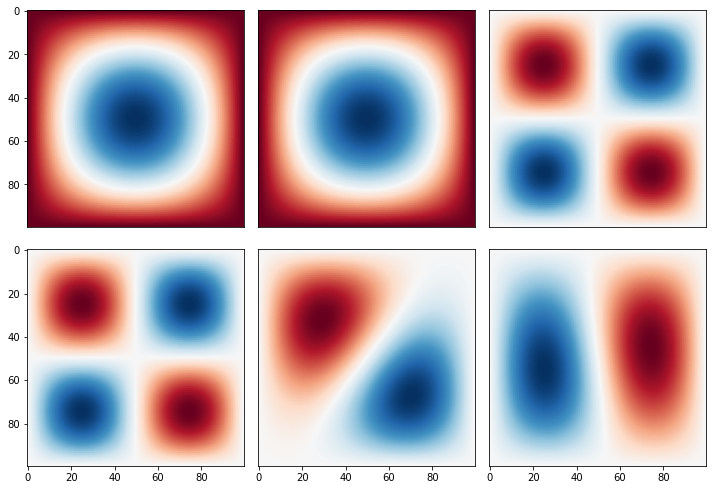

In [7]:
plt.figure(figsize = (10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.imshow(np.real(hy), cmap = 'RdBu')
    if(i<3):
        plt.xticks([])
    if(i!= 0 and i!=3):
        plt.yticks([])
plt.savefig('../img/conductor_3D_waveguide.png',dpi = 300)
plt.tight_layout();
plt.show();

In [8]:
## try to do a 3d plot of this waveguide

## Circular Metal Waveguide

[-5e-07, 5e-07]


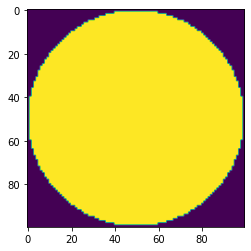

In [10]:
# ## use eigs
# from eigenwell.src.eigen_guide import *
# fd = grid.FiniteDifference(dL,N)

# eigen3D = EigenGuide3D(epsilon, fd)
print(xrange)

x = np.linspace(xrange[0],xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])

X,Y = np.meshgrid(x,y)

eps_r = np.ones(N);
mask = np.zeros(N);
mask[X**2+Y**2<(5e-7)**2] = 1;
plt.imshow(mask)

pec_pmc_obj.set_custom_mask(mask);

Mcircle = sp.bmat([[pec_pmc_obj.mask,None],[None,pec_pmc_obj.mask]]);

Acirc = omega**2*MU0*Tep + Mcircle@(Tep@(Dop1)@invTez@(Dop2)  + Dop3@Dop4)@Mcircle 


In [18]:
vals, vecs = eigs(Acirc, k = 12, which = 'SM')

<ipython-input-29-ed1047575620>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X/1e-6,Y/1e-6,np.real(hy), cmap = 'RdBu')


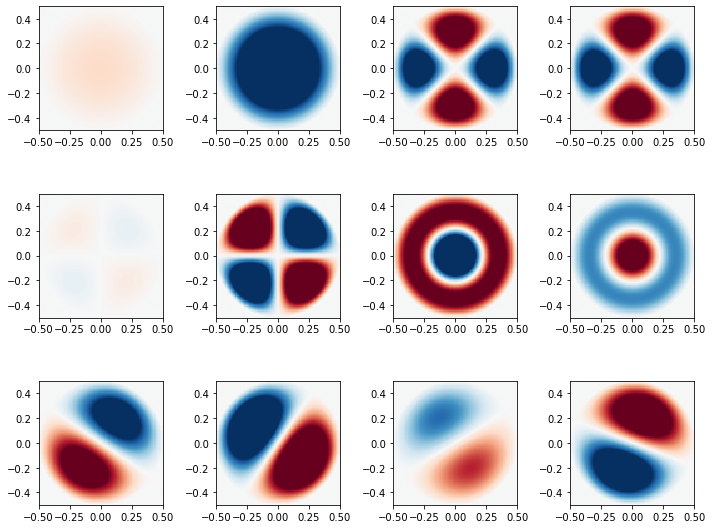

In [29]:
plt.figure(figsize = (10,8))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.pcolormesh(X/1e-6,Y/1e-6,np.real(hy), cmap = 'RdBu')
    plt.clim(-0.01, 0.01)
    ax.set_aspect('equal')
plt.tight_layout();

plt.savefig('metal_cylindrical_waveguide.png',dpi = 300)

In [42]:
print(np.min(np.real(hx)))

-0.021741660768675137


6006547.325490632
0.0 6006547.325490632 0.0


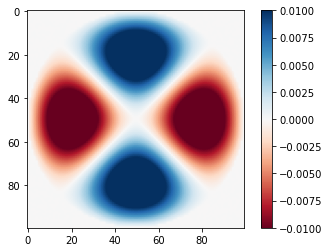

0.12134439041395216 6006547.325490632 2.02020202020202e-08


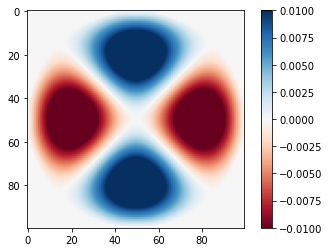

0.24268878082790432 6006547.325490632 4.04040404040404e-08


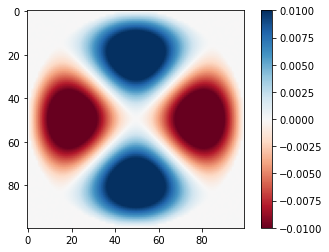

0.3640331712418565 6006547.325490632 6.060606060606061e-08


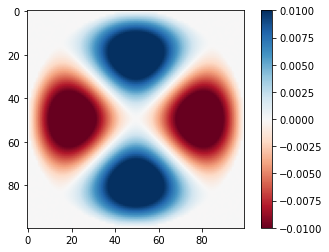

0.48537756165580864 6006547.325490632 8.08080808080808e-08


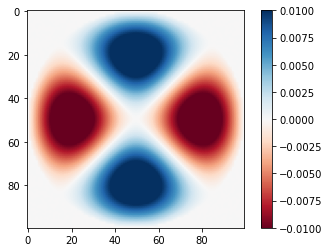

0.6067219520697608 6006547.325490632 1.01010101010101e-07


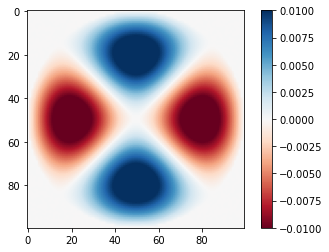

0.728066342483713 6006547.325490632 1.2121212121212122e-07


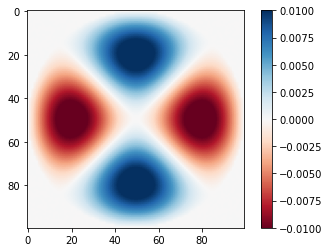

0.8494107328976651 6006547.325490632 1.4141414141414141e-07


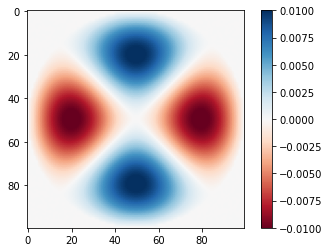

0.9707551233116173 6006547.325490632 1.616161616161616e-07


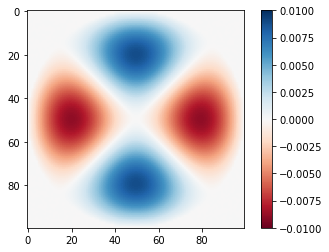

1.0920995137255693 6006547.325490632 1.818181818181818e-07


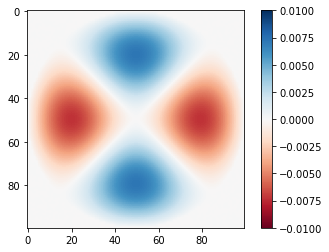

1.2134439041395215 6006547.325490632 2.02020202020202e-07


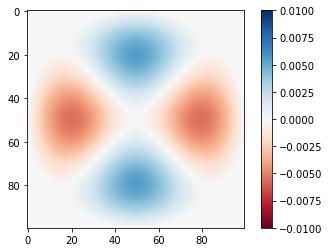

1.3347882945534737 6006547.325490632 2.2222222222222222e-07


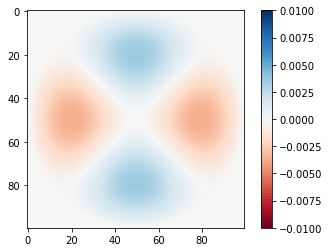

1.456132684967426 6006547.325490632 2.4242424242424244e-07


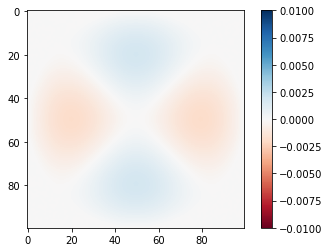

1.577477075381378 6006547.325490632 2.626262626262626e-07


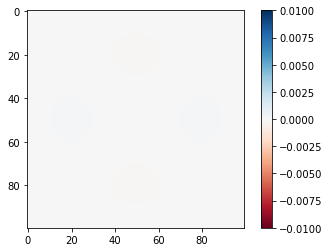

1.6988214657953302 6006547.325490632 2.8282828282828283e-07


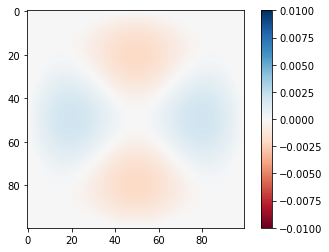

1.8201658562092822 6006547.325490632 3.03030303030303e-07


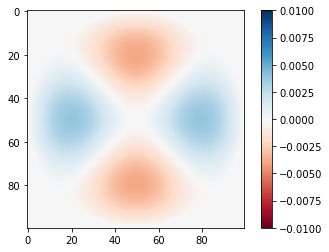

1.9415102466232346 6006547.325490632 3.232323232323232e-07


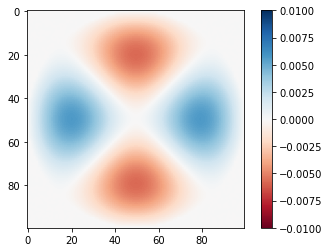

2.0628546370371867 6006547.325490632 3.4343434343434344e-07


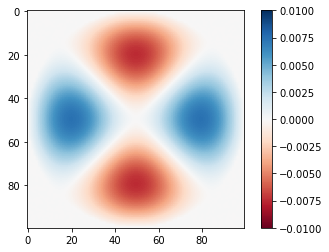

2.1841990274511387 6006547.325490632 3.636363636363636e-07


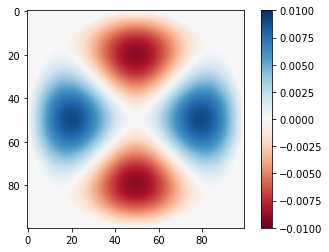

2.305543417865091 6006547.325490632 3.838383838383838e-07


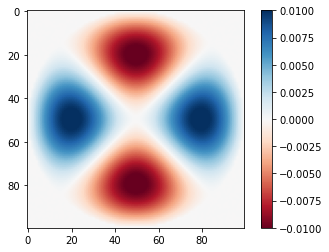

2.426887808279043 6006547.325490632 4.04040404040404e-07


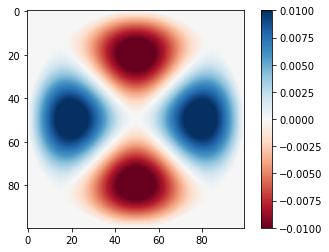

2.5482321986929954 6006547.325490632 4.242424242424242e-07


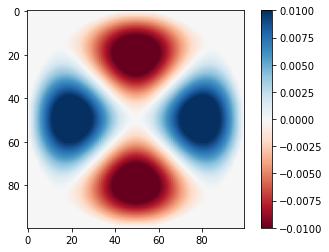

2.6695765891069474 6006547.325490632 4.4444444444444444e-07


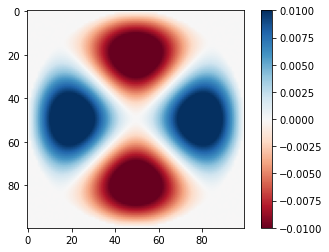

2.7909209795208993 6006547.325490632 4.646464646464646e-07


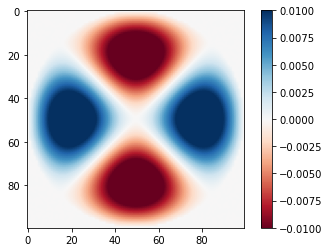

2.912265369934852 6006547.325490632 4.848484848484849e-07


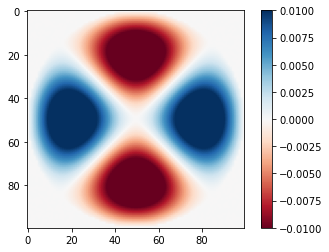

3.033609760348804 6006547.325490632 5.05050505050505e-07


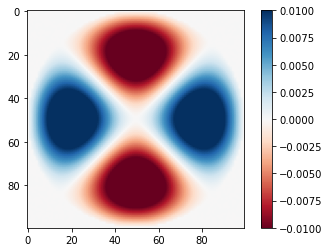

3.154954150762756 6006547.325490632 5.252525252525252e-07


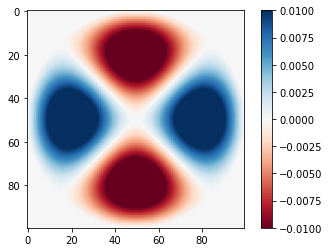

3.276298541176708 6006547.325490632 5.454545454545454e-07


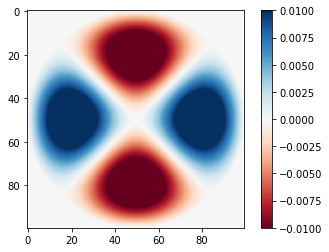

3.3976429315906604 6006547.325490632 5.656565656565657e-07


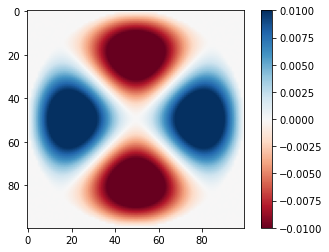

3.5189873220046124 6006547.325490632 5.858585858585858e-07


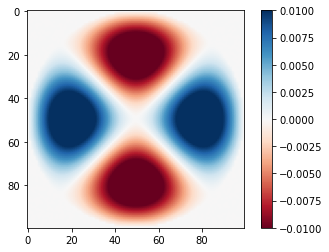

3.6403317124185643 6006547.325490632 6.06060606060606e-07


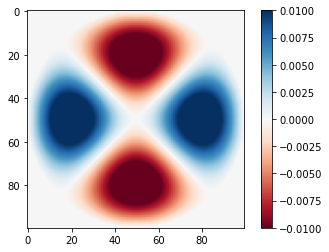

3.761676102832517 6006547.325490632 6.262626262626263e-07


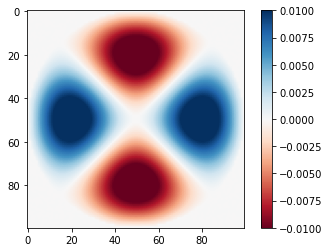

3.883020493246469 6006547.325490632 6.464646464646464e-07


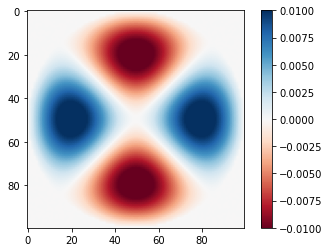

4.004364883660421 6006547.325490632 6.666666666666666e-07


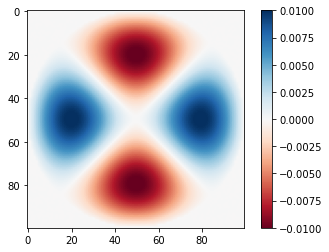

4.1257092740743735 6006547.325490632 6.868686868686869e-07


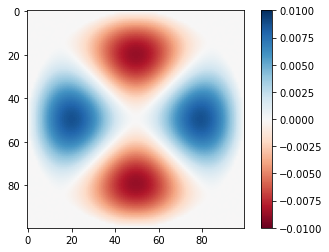

4.247053664488326 6006547.325490632 7.07070707070707e-07


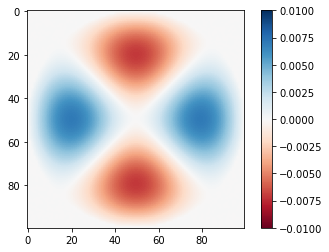

4.368398054902277 6006547.325490632 7.272727272727272e-07


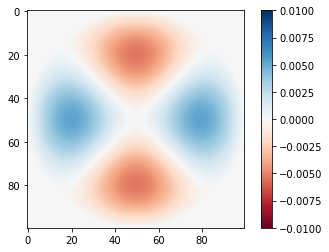

4.48974244531623 6006547.325490632 7.474747474747475e-07


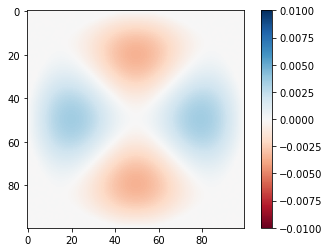

4.611086835730182 6006547.325490632 7.676767676767677e-07


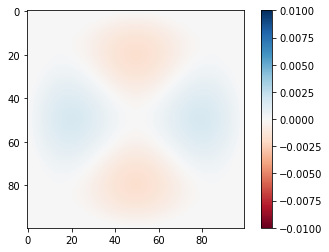

4.732431226144134 6006547.325490632 7.878787878787878e-07


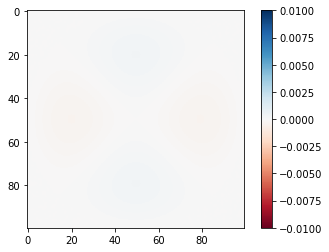

4.853775616558086 6006547.325490632 8.08080808080808e-07


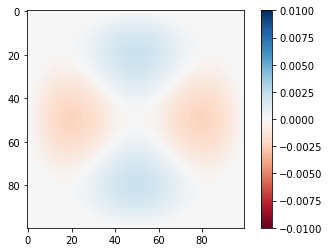

4.9751200069720385 6006547.325490632 8.282828282828283e-07


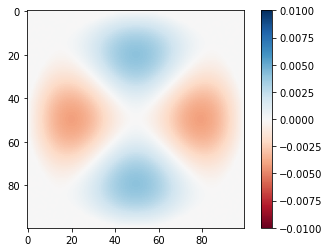

5.096464397385991 6006547.325490632 8.484848484848484e-07


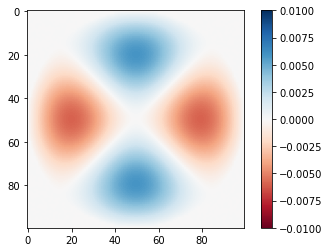

5.217808787799942 6006547.325490632 8.686868686868686e-07


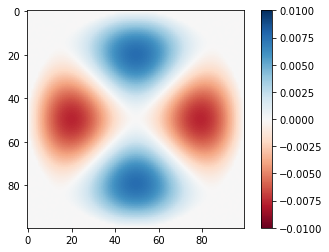

5.339153178213895 6006547.325490632 8.888888888888889e-07


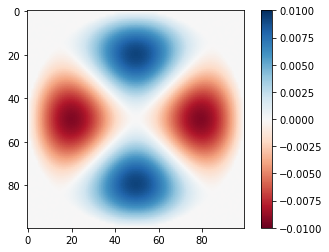

5.460497568627847 6006547.325490632 9.09090909090909e-07


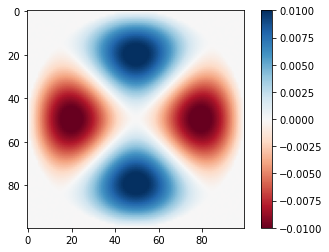

5.581841959041799 6006547.325490632 9.292929292929292e-07


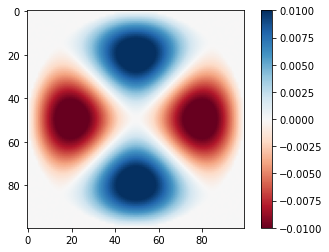

5.703186349455752 6006547.325490632 9.494949494949495e-07


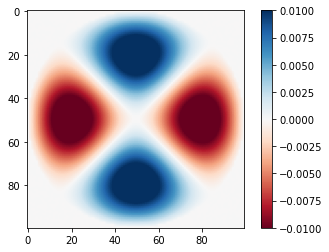

5.824530739869704 6006547.325490632 9.696969696969698e-07


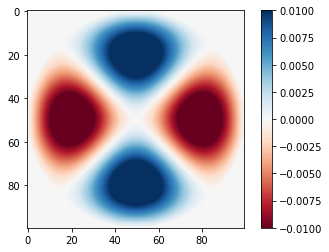

5.945875130283656 6006547.325490632 9.898989898989898e-07


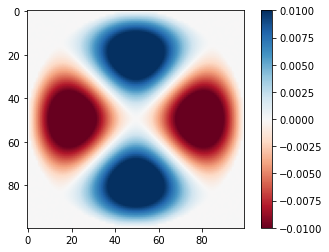

6.067219520697608 6006547.325490632 1.01010101010101e-06


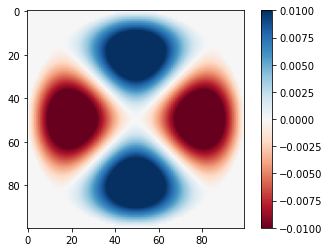

6.18856391111156 6006547.325490632 1.0303030303030302e-06


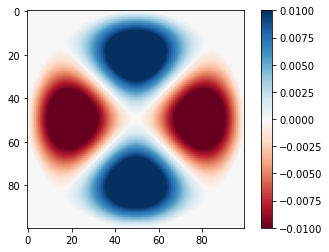

6.309908301525512 6006547.325490632 1.0505050505050504e-06


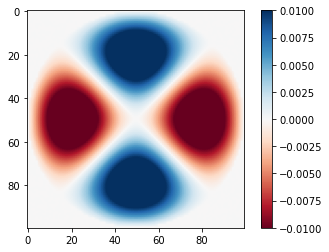

6.431252691939465 6006547.325490632 1.0707070707070707e-06


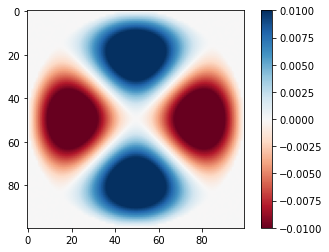

6.552597082353416 6006547.325490632 1.0909090909090908e-06


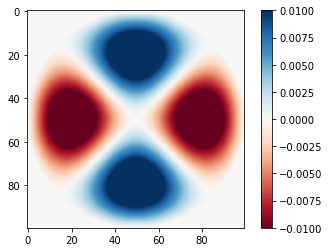

6.6739414727673685 6006547.325490632 1.111111111111111e-06


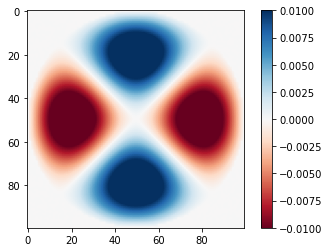

6.795285863181321 6006547.325490632 1.1313131313131313e-06


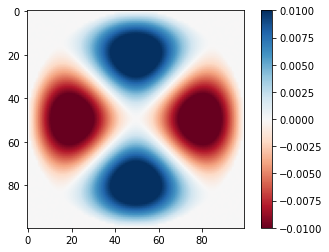

6.916630253595272 6006547.325490632 1.1515151515151514e-06


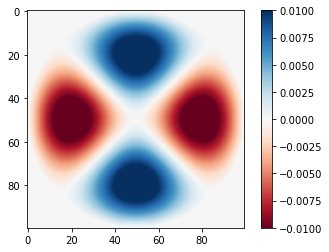

7.037974644009225 6006547.325490632 1.1717171717171716e-06


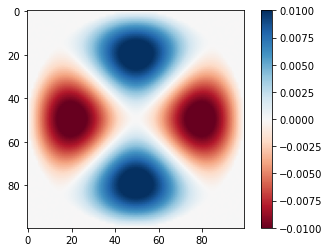

7.159319034423178 6006547.325490632 1.191919191919192e-06


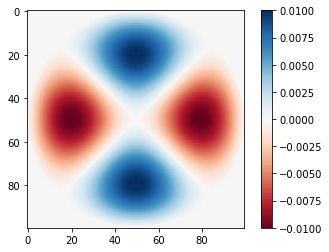

7.280663424837129 6006547.325490632 1.212121212121212e-06


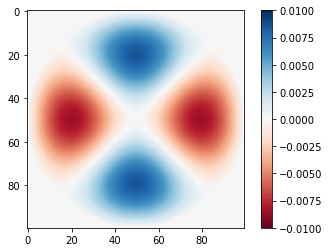

7.402007815251082 6006547.325490632 1.2323232323232323e-06


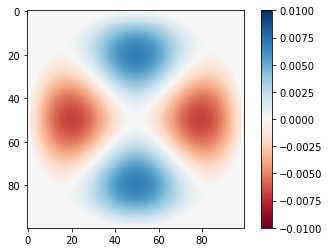

7.523352205665034 6006547.325490632 1.2525252525252525e-06


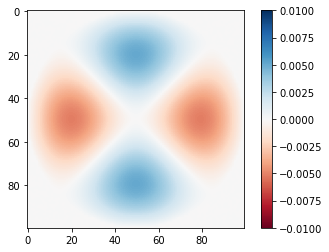

7.644696596078986 6006547.325490632 1.2727272727272726e-06


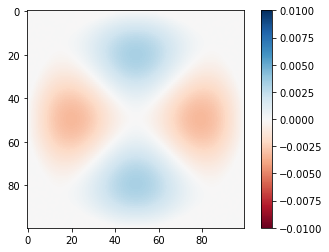

7.766040986492938 6006547.325490632 1.2929292929292929e-06


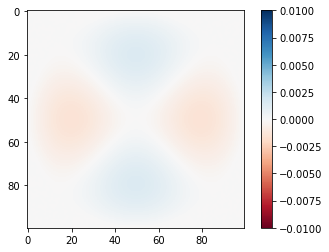

7.887385376906891 6006547.325490632 1.3131313131313131e-06


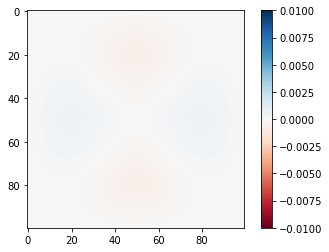

8.008729767320842 6006547.325490632 1.3333333333333332e-06


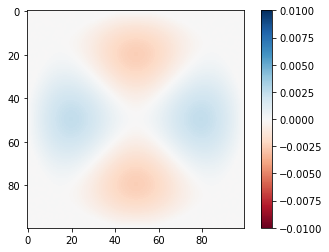

8.130074157734795 6006547.325490632 1.3535353535353535e-06


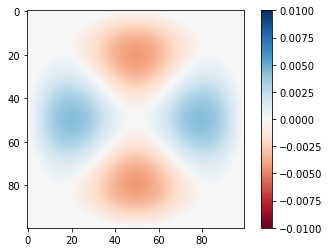

8.251418548148747 6006547.325490632 1.3737373737373738e-06


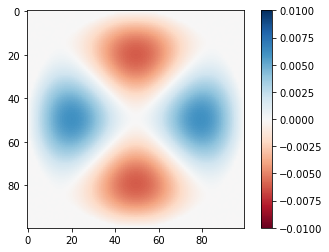

8.3727629385627 6006547.325490632 1.3939393939393938e-06


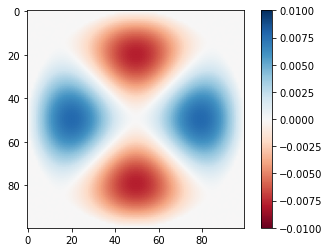

8.494107328976652 6006547.325490632 1.414141414141414e-06


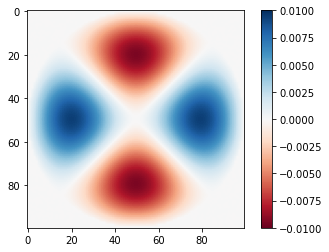

8.615451719390604 6006547.325490632 1.4343434343434344e-06


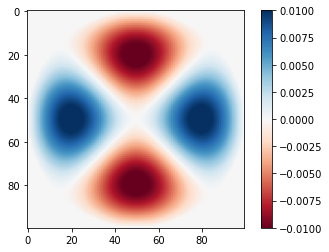

8.736796109804555 6006547.325490632 1.4545454545454544e-06


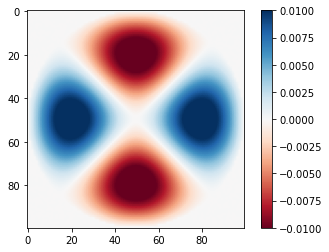

8.858140500218507 6006547.325490632 1.4747474747474747e-06


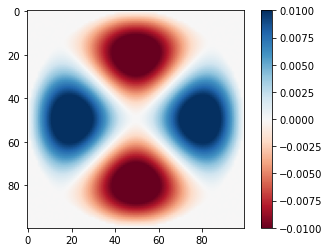

8.97948489063246 6006547.325490632 1.494949494949495e-06


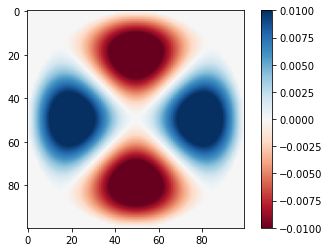

9.100829281046412 6006547.325490632 1.515151515151515e-06


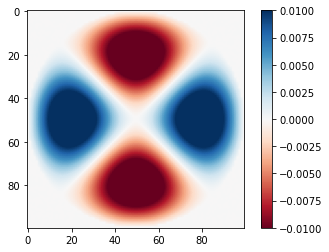

9.222173671460364 6006547.325490632 1.5353535353535353e-06


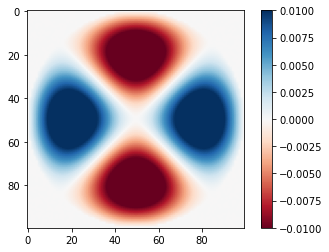

9.343518061874317 6006547.325490632 1.5555555555555556e-06


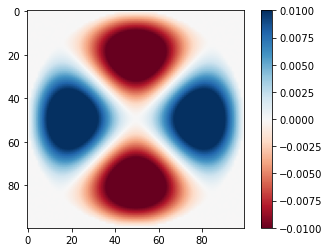

9.464862452288267 6006547.325490632 1.5757575757575756e-06


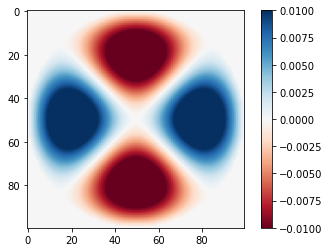

9.58620684270222 6006547.325490632 1.595959595959596e-06


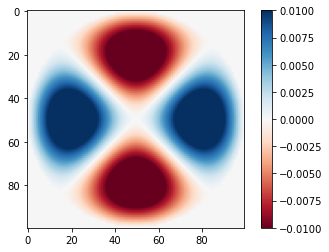

9.707551233116172 6006547.325490632 1.616161616161616e-06


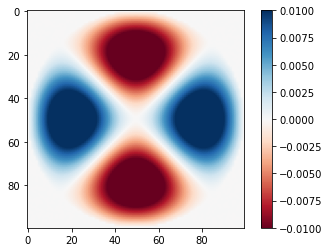

9.828895623530125 6006547.325490632 1.6363636363636363e-06


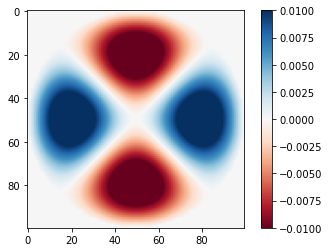

9.950240013944077 6006547.325490632 1.6565656565656565e-06


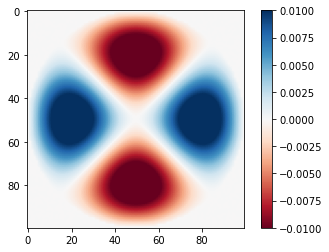

10.07158440435803 6006547.325490632 1.6767676767676766e-06


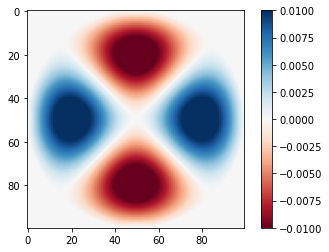

10.192928794771982 6006547.325490632 1.6969696969696969e-06


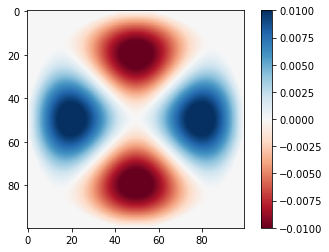

10.314273185185934 6006547.325490632 1.7171717171717171e-06


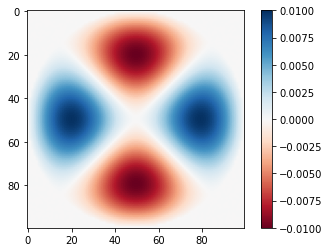

10.435617575599885 6006547.325490632 1.7373737373737372e-06


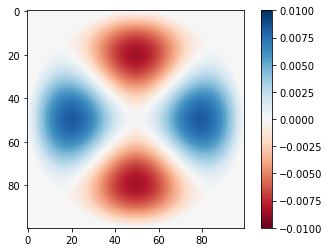

10.556961966013837 6006547.325490632 1.7575757575757575e-06


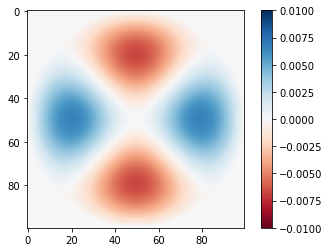

10.67830635642779 6006547.325490632 1.7777777777777777e-06


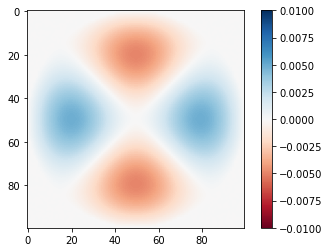

10.799650746841742 6006547.325490632 1.7979797979797978e-06


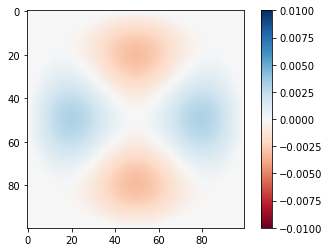

10.920995137255694 6006547.325490632 1.818181818181818e-06


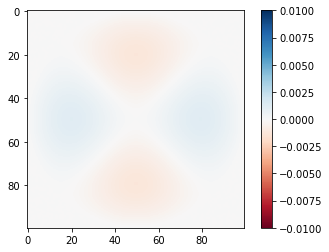

11.042339527669647 6006547.325490632 1.8383838383838384e-06


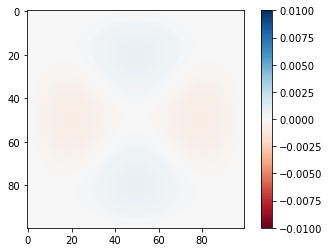

11.163683918083597 6006547.325490632 1.8585858585858584e-06


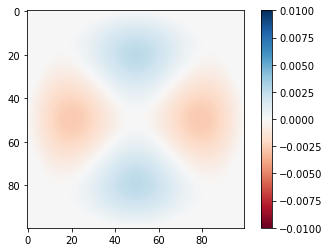

11.28502830849755 6006547.325490632 1.8787878787878787e-06


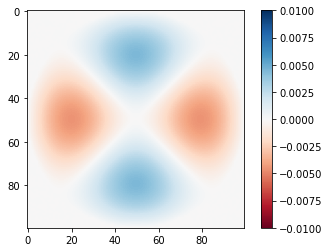

11.406372698911504 6006547.325490632 1.898989898989899e-06


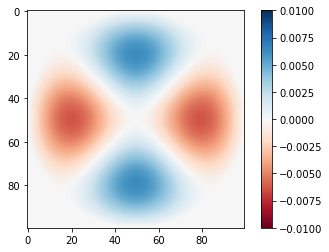

11.527717089325456 6006547.325490632 1.9191919191919192e-06


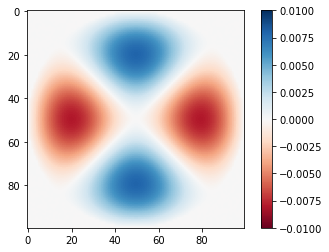

11.649061479739409 6006547.325490632 1.9393939393939395e-06


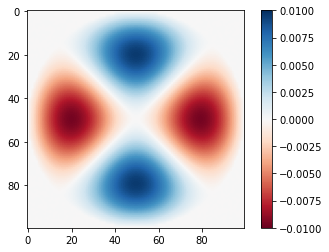

11.770405870153358 6006547.325490632 1.9595959595959594e-06


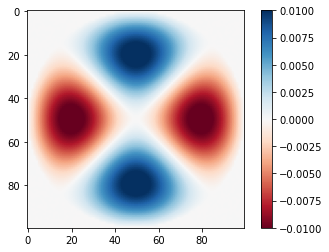

11.891750260567312 6006547.325490632 1.9797979797979796e-06


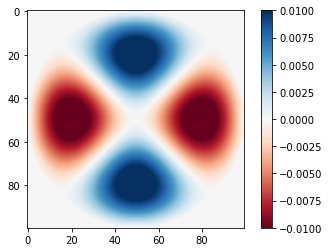

12.013094650981264 6006547.325490632 2e-06


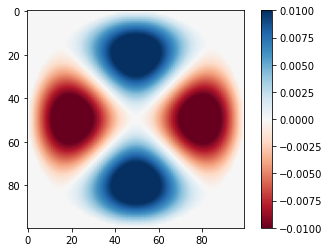

In [61]:
import plotly.graph_objects as go


## make a 3D image of this based on beta...
z_scan = np.linspace(0, 2e-6, 100)
X,Y,Z = np.meshgrid(x,y,z_scan)

i = 2

field_slices = [];
v = vecs[:,i]
beta_squared = vals[i]
beta = np.abs(np.sqrt(beta_squared));
print(beta)
hx = v[0:np.prod(N)].reshape(N)
hy = v[np.prod(N):].reshape(N)
for z in z_scan:
    field_slices.append(hx*np.exp(1j*beta*z));
    print(beta*z, beta, z)
    plt.imshow(np.real(field_slices[-1]), cmap = 'RdBu')
    plt.clim(-0.01, 0.01)
    plt.colorbar();
    plt.show()
field_slices = np.array(field_slices)

    


(-36078610773358.664+0j)